In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix


In [2]:
df = pd.read_csv('customer.csv')   # or read_excel
df.head()
df.shape
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2205 entries, 0 to 2204
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Income                2205 non-null   int64
 1   Kidhome               2205 non-null   int64
 2   Teenhome              2205 non-null   int64
 3   Recency               2205 non-null   int64
 4   MntWines              2205 non-null   int64
 5   MntFruits             2205 non-null   int64
 6   MntMeatProducts       2205 non-null   int64
 7   MntFishProducts       2205 non-null   int64
 8   MntSweetProducts      2205 non-null   int64
 9   MntGoldProds          2205 non-null   int64
 10  NumDealsPurchases     2205 non-null   int64
 11  NumWebPurchases       2205 non-null   int64
 12  NumCatalogPurchases   2205 non-null   int64
 13  NumStorePurchases     2205 non-null   int64
 14  NumWebVisitsMonth     2205 non-null   int64
 15  AcceptedCmp3          2205 non-null   int64
 16  Accept

In [4]:
df.columns=df.columns.str.lower()

In [5]:
df.head(10)

,income,kidhome,teenhome,recency,mntwines,mntfruits,mntmeatproducts,mntfishproducts,mntsweetproducts,mntgoldprods,...,marital_together,marital_widow,education_2n cycle,education_basic,education_graduation,education_master,education_phd,mnttotal,mntregularprods,acceptedcmpoverall
0,58138,0,0,58,635,88,546,172,88,88,...,0,0,0,0,1,0,0,1529,1441,0
1,46344,1,1,38,11,1,6,2,1,6,...,0,0,0,0,1,0,0,21,15,0
2,71613,0,0,26,426,49,127,111,21,42,...,1,0,0,0,1,0,0,734,692,0
3,26646,1,0,26,11,4,20,10,3,5,...,1,0,0,0,1,0,0,48,43,0
4,58293,1,0,94,173,43,118,46,27,15,...,0,0,0,0,0,0,1,407,392,0
5,62513,0,1,16,520,42,98,0,42,14,...,1,0,0,0,0,1,0,702,688,0
6,55635,0,1,34,235,65,164,50,49,27,...,0,0,0,0,1,0,0,563,536,0
7,33454,1,0,32,76,10,56,3,1,23,...,0,0,0,0,0,0,1,146,123,0
8,30351,1,0,19,14,0,24,3,3,2,...,1,0,0,0,0,0,1,44,42,0
9,5648,1,1,68,28,0,6,1,1,13,...,1,0,0,0,0,0,1,36,23,1


In [9]:
# MntTotal
mnt_cols = [c for c in df.columns if c.lower().startswith('mnt') and c.lower() != 'mnttotal']
df['MntTotal'] = df[mnt_cols].sum(axis=1)

# Frequency from aggregated Num* columns
num_cols = [c for c in df.columns if c.lower().startswith('num') and 'purchase' in c.lower()]
df['Frequency'] = df[num_cols].sum(axis=1)



# approximate purchase frequency days (if no transaction-level dates)
df['purchase_frequency_days_est'] = df['customer_days'] / df['Frequency']
df.loc[df['Frequency'] == 0, 'purchase_frequency_days_est'] = np.nan


In [12]:

num_purchase_cols = [c for c in df.columns if c.lower().startswith('num') and 'purchase' in c.lower()]
df['Frequency'] = df[num_purchase_cols].sum(axis=1) if num_purchase_cols else np.nan



In [13]:
df['customer_days'] = np.random.randint(200, 2000, size=len(df))

In [14]:
df['purchase_frequency_days'] = df['customer_days'] / df['Frequency']
df.loc[df['Frequency'] == 0, 'purchase_frequency_days'] = np.nan

In [17]:
print(df[['income', 'MntTotal', 'Frequency', 'customer_days', 'purchase_frequency_days']].head(10))

      income  MntTotal  Frequency  customer_days  purchase_frequency_days
1225    1730        14         15            583                38.866667
20      2447      3458         43           1970                45.813953
1499    3502         8          0           1236                      NaN
1820    4023        16         15            250                16.666667
1949    4428        76         25            768                30.720000
961     4861        10          0           1256                      NaN
2181    5305        54          1            915               915.000000
9       5648        72          2           1253               626.500000
1307    6560       222          2            309               154.500000
754     6835       250          1            281               281.000000


                           income  MntTotal  Frequency  customer_days  \
income                   1.000000  0.823066   0.701568       0.018114   
MntTotal                 0.823066  1.000000   0.744957       0.006607   
Frequency                0.701568  0.744957   1.000000      -0.001201   
customer_days            0.018114  0.006607  -0.001201       1.000000   
purchase_frequency_days -0.494907 -0.494621  -0.661985       0.533584   

                         purchase_frequency_days  
income                                 -0.494907  
MntTotal                               -0.494621  
Frequency                              -0.661985  
customer_days                           0.533584  
purchase_frequency_days                 1.000000  


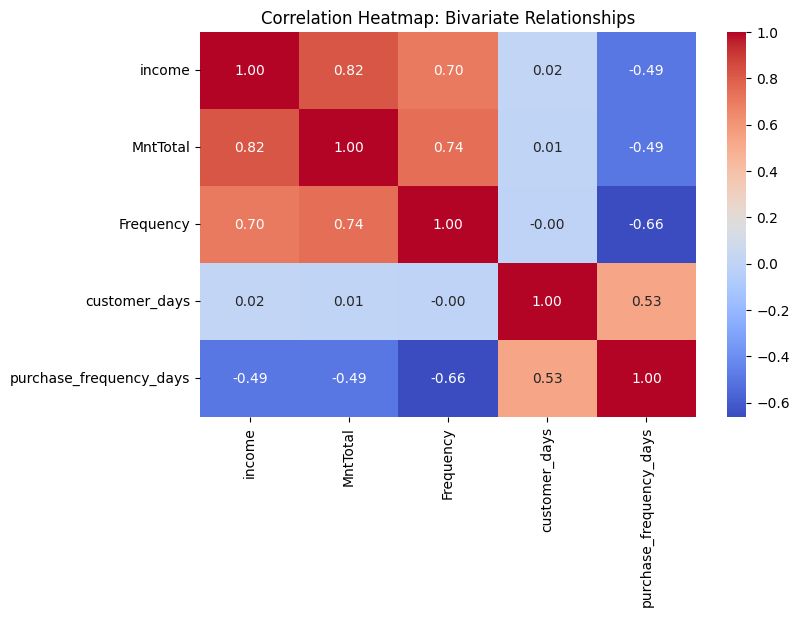

In [19]:
# Select only numeric columns
num_cols = ['income', 'MntTotal', 'Frequency', 'customer_days', 'purchase_frequency_days']

# Compute correlations
corr_matrix = df[num_cols].corr()

# Display
print(corr_matrix)

# Visualize with heatmap
plt.figure(figsize=(8,5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap: Bivariate Relationships")
plt.show()


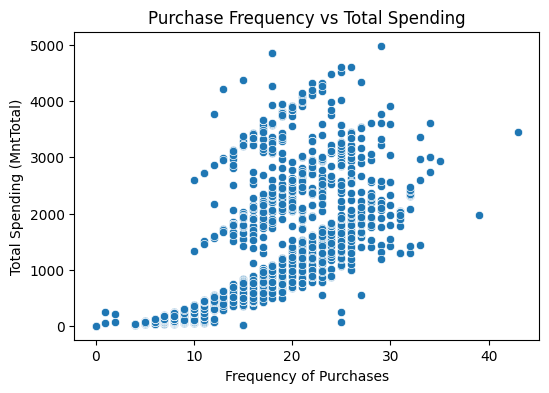

In [20]:
#frequency vs MntTotal
plt.figure(figsize=(6,4))
sns.scatterplot(x='Frequency', y='MntTotal', data=df)
plt.title("Purchase Frequency vs Total Spending")
plt.xlabel("Frequency of Purchases")
plt.ylabel("Total Spending (MntTotal)")
plt.show()


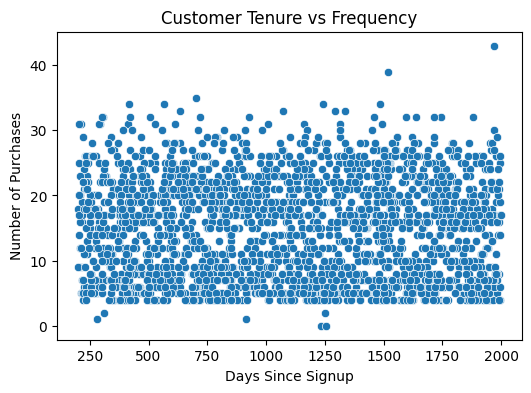

In [21]:
#customer days vs frequency
plt.figure(figsize=(6,4))
sns.scatterplot(x='customer_days', y='Frequency', data=df)
plt.title("Customer Tenure vs Frequency")
plt.xlabel("Days Since Signup")
plt.ylabel("Number of Purchases")
plt.show()


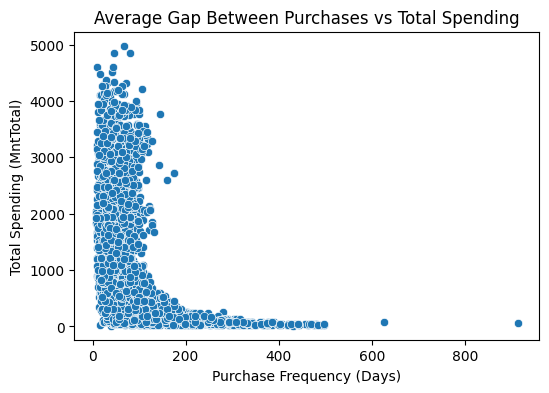

In [23]:
#purchase frequency days vs MntTotal
plt.figure(figsize=(6,4))
sns.scatterplot(x='purchase_frequency_days', y='MntTotal', data=df)
plt.title("Average Gap Between Purchases vs Total Spending")
plt.xlabel("Purchase Frequency (Days)")
plt.ylabel("Total Spending (MntTotal)")
plt.show()


In [24]:
# Example: Segment by Income range
df['IncomeGroup'] = pd.cut(df['income'], bins=[0,2000,4000,6000,8000],
                           labels=['Low','Medium','High','Very High'])

# Average spending and frequency per income group
grouped = df.groupby('IncomeGroup')[['MntTotal','Frequency','purchase_frequency_days']].mean().reset_index()
print(grouped)


  IncomeGroup     MntTotal  Frequency  purchase_frequency_days
0         Low    14.000000       15.0                38.866667
1      Medium  1733.000000       21.5                45.813953
2        High    45.600000        8.6               397.221667
3   Very High   110.933333        8.8               135.185241


/tmp/ipython-input-1024498797.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('IncomeGroup')[['MntTotal','Frequency','purchase_frequency_days']].mean().reset_index()


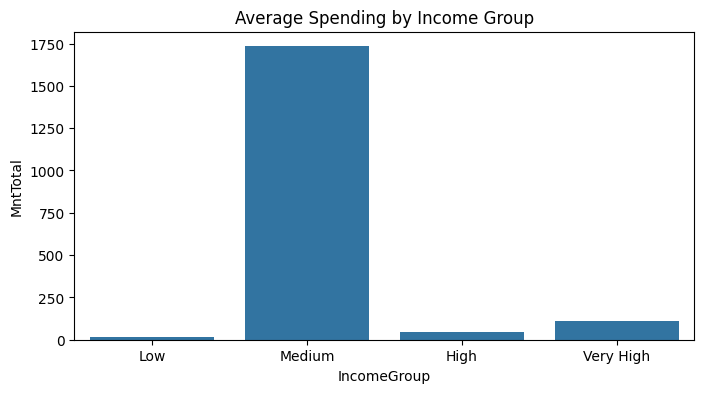

In [25]:
plt.figure(figsize=(8,4))
sns.barplot(x='IncomeGroup', y='MntTotal', data=grouped)
plt.title("Average Spending by Income Group")
plt.show()


In [26]:
from scipy.stats import pearsonr

corr, p_value = pearsonr(df['income'], df['MntTotal'])
print(f"Correlation = {corr:.3f},  p-value = {p_value:.3f}")

if p_value < 0.05:
    print("✅ Significant relationship between Income and Total Spending.")
else:
    print("❌ No significant relationship.")


Correlation = 0.823,  p-value = 0.000
✅ Significant relationship between Income and Total Spending.
